In [47]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import os
import re
from time import sleep
from matplotlib.animation import FuncAnimation
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Load Parameters

In [101]:
def save_param(cpp_file_path="M6.cpp"):
    # Define the regex pattern to match C++ variable declarations and their values
    variable_pattern = r'\b(?:int|double|string)\s+(\w+)\s*=\s*([^;]+);'
    # Initialize a flag to check if we are within the desired block
    inside_block = False
    # Initialize an empty dictionary to store variable names and values
    variable_dict = {}
            
    print(cpp_file_path)
    # Read the file line by line and process it
    with open(cpp_file_path, 'r') as file:
        for line in file:
            # Check if we are entering the block
            if "//params-begin" in line:
                inside_block = True
                continue

            # Check if we are exiting the block
            if "//params-end" in line:
                inside_block = False
                break

            # If we are inside the block, try to match variable declarations and values
            if inside_block:
                match = re.match(variable_pattern, line.strip())
                if match:
                    variable_name = match.group(1)
                    variable_value = match.group(2)
                    variable_dict[variable_name] = variable_value

    # Print the extracted variable names and values
    with open("params.csv","w")as f:
        for variable_name, variable_value in variable_dict.items():
            f.write(f"{variable_name},{variable_value}\n")
    return variable_dict

In [102]:
variable_dict=save_param()

box_size=float(variable_dict["boxSize"])
r=float(variable_dict["sigma"])/2.0
dataCompression=int(variable_dict["dataCompression"])
numSteps=int(variable_dict["numSteps"])
timestep=float(variable_dict["timestep"])
numParticles=int(variable_dict["numParticles"])
theta=(variable_dict["theta"])

M6.cpp


# Load Data

In [103]:
# Load the JSON file
with open('particle_positions.json', 'r') as file:
    data = json.load(file)

# Convert the data to a NumPy array
particle_positions = np.array(data)

# Plot Energy

In [88]:
def energy_plotly_plotter(xlabel, ylabel, legend_names, colors):
    # Read data from the file
    
    # Load the JSON file
    with open('particle_positions.json', 'r') as file:
        data = json.load(file)

    # Convert the data to a NumPy array
    particle_positions = np.array(data)

    time = []
    kinetic_energy = []
    potential_energy = []
    total_energy = []

    for t in range(len(particle_positions)):
        time.append(float(t)*dataCompression*timestep)
        kinetic_energy_total=0.0
        i=0
        for x, y ,vx ,vy , phi, PE in particle_positions[t]:
            kinetic_energy_total+=(float(0.5 * (vx**2 + vy**2)))
            if i==len(particle_positions[0])-1:
                potential_energy_per_particle=float(PE)
                kinetic_energy_per_particle=kinetic_energy_total/float(len(particle_positions[0]))
            i+=1
        potential_energy.append(potential_energy_per_particle)
        kinetic_energy.append(kinetic_energy_per_particle)
        total_energy.append(potential_energy_per_particle+kinetic_energy_per_particle)

    # Create Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=time, y=kinetic_energy, mode='lines', name=legend_names[0], line=dict(color=colors[0])))
    fig.add_trace(go.Scatter(x=time, y=potential_energy, mode='lines', name=legend_names[1], line=dict(color=colors[1])))
    fig.add_trace(go.Scatter(x=time, y=total_energy, mode='lines', name=legend_names[2], line=dict(color=colors[2])))

    fig.update_layout(title="Energy Plot", xaxis_title=xlabel, yaxis_title=ylabel, width=1200, height=600)

    # Save or show the plot
    # pio.write_image(fig, 'tempi.png')
    pio.write_html(fig, 'tempi.html')


In [ ]:
# Save the plot as PNG
f=0
legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
colors = ['blue', 'green', 'red']
while True:
        energy_plotly_plotter("Time", "Energy per Particle", legend_names, colors)
        if f<1:
            os.system(f"start {os.getcwd()}/tempi.html")
        f+=1
        sleep(10) #change to increase delay

# Final Frame Plotter

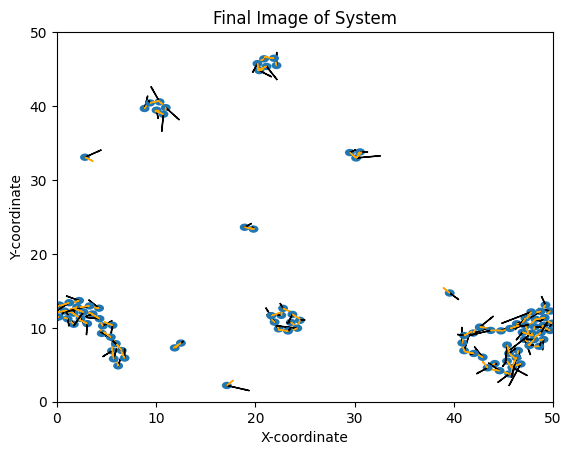

<Figure size 640x480 with 0 Axes>

In [104]:
def FinalSysImagePlotter():
    # Create a figure and axis for the Plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    
    for x, y ,vx ,vy , phi, PE in particle_positions[-1]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)
    
    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, vx, vy, width=0.1, color='black')
        ax.add_patch(arrow)
        
    # Add an arrow to represent the vision direction
        arrow = plt.Arrow(x, y, np.cos(phi), np.sin(phi), width=0.1, color='orange')
        ax.add_patch(arrow)
    
    # Set axis labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Final Image of System')
    
    # Show the plot
    plt.show()
    plt.savefig("FinalFrame.png")

#Plots the final system image
FinalSysImagePlotter()

# Animation

In [ ]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Function to update the animation
def update(frame):
    ax.clear()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Plot the particles at the given frame as circles
    for x, y , vx, vy, phi, PE in particle_positions[frame]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)
        
    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, vx, vy, width=0.1, color='red')
        ax.add_patch(arrow)

    # Add an arrow to represent the direction of movement
        arrow = plt.Arrow(x, y, np.cos(phi), np.sin(phi), width=0.1, color='green')
        ax.add_patch(arrow)

# Create the animation
animation = FuncAnimation(fig, update, frames=len(particle_positions), interval=100)

# Save the animation as a GIF
# animation.save('particle_animation.gif', writer='pillow')  # For GIF
# Save the animation as a video
animation.save('particle_animation.mp4', writer='ffmpeg')  # For MP4


# Persistence and Fourier Transform of Persistence

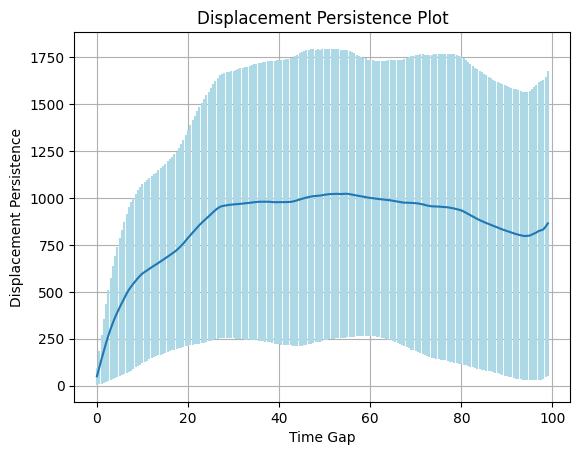

In [105]:
def displacement_persistence():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    # Create a list which stores the average persistence of each particle at a given gap
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)
    # Create a list to store the standard deviation of persistence values at each gap
    stdPersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 1):
                # For each k calculate the squared displacement between the two points under consideration and add it to the list
                dx = float(data[k+j+1][i][0]) - float(data[k][i][0])
                dy = float(data[k+j+1][i][1]) - float(data[k][i][1])
                persistencePerGap[j] += dx*dx + dy*dy

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= (len(data) - j - 1)

        # Add the list to the list of lists
        persistencePerParticle[i] = persistencePerGap


    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        # Create a list to store the persistence values of each particle at a given gap
        persistenceValues = []

        # Create a for loop running through each particle
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        stdPersistence = np.std(persistenceValues)

        # Store the mean and standard deviation in the respective lists
        averagePersistencePerGap[j] = meanPersistence
        stdPersistencePerGap[j] = stdPersistence

    # Plot displacement persistence using matplotlib with x axis as i*dataCompression*timestep and y axis as averagePersistencePerGap[i]
    plt.errorbar([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, yerr=stdPersistencePerGap, ecolor = 'lightblue', capsize=0)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Displacement Persistence")
    plt.title("Displacement Persistence Plot")
    plt.savefig("displacement_persistence.png")
    

displacement_persistence()

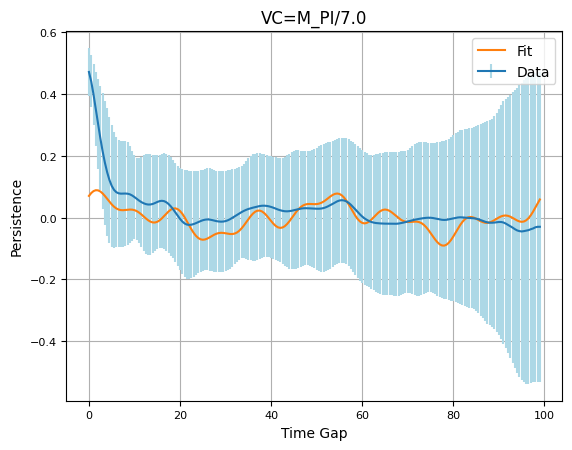

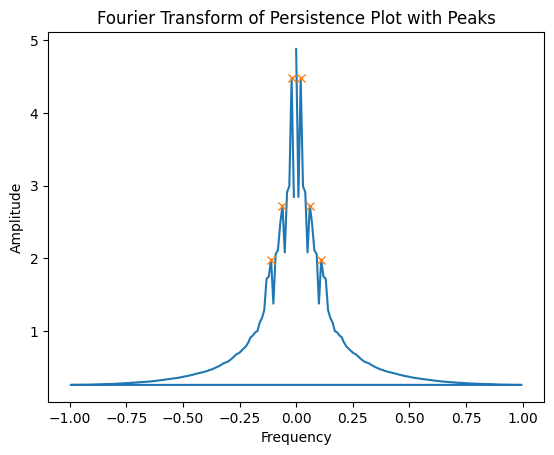

In [106]:
def persistenceFit():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    # Create a list which stores the average persistence of each particle at a given gap
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)
    # Create a list to store the standard deviation of persistence values at each gap
    stdPersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 1):
                # For each k calculate (cos(data[k][i][4])*cos(data[k+j+1][i][4]))/(cos(data[k][i][4]*cos(data[k][i][4]) and add it to the list
                # cos function is being called with an argument of type float which is a double in C++
                persistencePerGap[j] += (math.cos(float(data[k][i][4])) * math.cos(float(data[k+j+1][i][4]))) # /(math.cos(float(data[0][i][4])) * math.cos(float(data[0][i][4])))

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= (len(data) - j - 1)
        persistencePerParticle[i] = persistencePerGap

    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        stdPersistence = np.std(persistenceValues)
        
        # Store the mean and standard deviation in the respective lists
        averagePersistencePerGap[j] = meanPersistence
        stdPersistencePerGap[j] = stdPersistence

    
    # Calculate the Fourier transform of the persistence data
    fft = np.fft.fft(averagePersistencePerGap)
    freq = np.fft.fftfreq(len(averagePersistencePerGap), d=(dataCompression*timestep))

    # Find the peaks in the Fourier transform
    peaks, properties = find_peaks(np.abs(fft), prominence=(0.1, None))
    # Create a new frequency spectrum with zeros everywhere
    new_fft = np.zeros_like(fft)
    # Set the values at the major peak indices to the original complex amplitudes
    new_fft[peaks] = fft[peaks]
    # Perform Inverse Fourier Transform
    reconstructed_signal = np.fft.ifft(new_fft)

    # Fit the averagePersistencePerGap data using the peak frequencies in the persistence plot
    # plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, label='Data')
    plt.errorbar([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, yerr=stdPersistencePerGap, ecolor = 'lightblue', capsize=0, label='Data')
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], reconstructed_signal, label='Fit')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.title("VC=" + theta)
    plt.legend()
    plt.savefig("persistence_Fit.png")
    
    #Plot the Fourier transform
    fig, ax = plt.subplots()
    ax.plot(freq, np.abs(fft))
    ax.plot(freq[peaks], np.abs(fft)[peaks], "x")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform of Persistence Plot with Peaks')
    plt.savefig("persistence_fft.png")
    

persistenceFit()

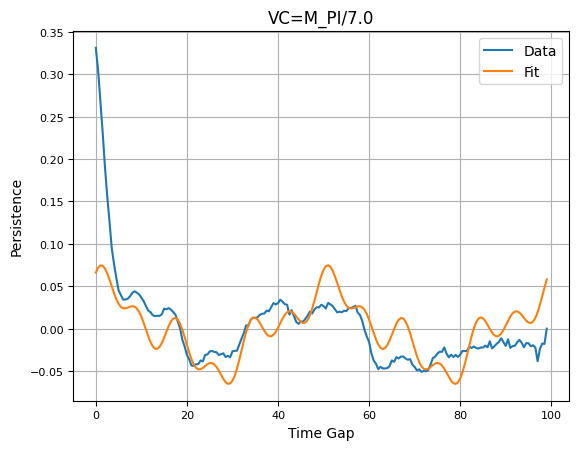

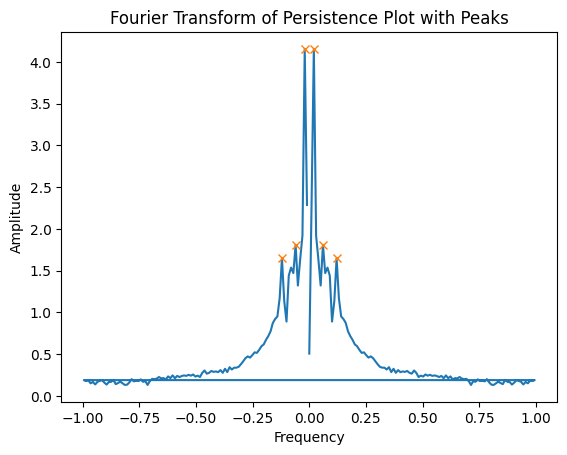

In [107]:
def persistenceFitV2():

    # Create an empty list to store the persistence list of each particle at each gap to take average later
    persistencePerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a for loop running through each particle
    for i in range(numParticles):
        # Create an empty list to store the persistence values of each gap
        persistencePerGap = [0.0] * math.floor(len(data) -1.0)

        # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 2):
                # For each k calculate (cos(data[k][i][4])*cos(data[k+j+1][i][4]))/(cos(data[k][i][4]*cos(data[k][i][4]) and add it to the list
                # cos function is being called with an argument of type float which is a double in C++
                cos1=(data[k+1][i][0] - data[k][i][0]) / math.sqrt((data[k+1][i][0] - data[k][i][0]) ** 2 + (data[k+1][i][1] - data[k][i][1]) ** 2)
                cos2=(data[k+j+2][i][0] - data[k+j+1][i][0]) / math.sqrt((data[k+j+2][i][0] - data[k+j+1][i][0]) ** 2 + (data[k+j+2][i][1] - data[k+j+1][i][1]) ** 2)
                
                persistencePerGap[j] += cos1 * cos2 

            # Take the average of the list and store it in the list
            persistencePerGap[j] /= (len(data) - j - 1)
        persistencePerParticle[i] = persistencePerGap

    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean and standard deviation of the persistence values
        meanPersistence = np.mean(persistenceValues)
        averagePersistencePerGap[j] = meanPersistence

    
    # Calculate the Fourier transform of the persistence data
    fft = np.fft.fft(averagePersistencePerGap)
    freq = np.fft.fftfreq(len(averagePersistencePerGap), d=(dataCompression*timestep))

    # Find the peaks in the Fourier transform
    peaks, properties = find_peaks(np.abs(fft), prominence=(0.2, None))
    # Create a new frequency spectrum with zeros everywhere
    new_fft = np.zeros_like(fft)
    # Set the values at the major peak indices to the original complex amplitudes
    new_fft[peaks] = fft[peaks]
    # Perform Inverse Fourier Transform
    reconstructed_signal = np.fft.ifft(new_fft)

    # Fit the averagePersistencePerGap data using the peak frequencies in the persistence plot
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averagePersistencePerGap, label='Data')
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], reconstructed_signal, label='Fit')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.title("VC=" + theta)
    plt.legend()
    plt.savefig("persistence_FitV2.png")
    
    #Plot the Fourier transform
    fig, ax = plt.subplots()
    ax.plot(freq, np.abs(fft))
    ax.plot(freq[peaks], np.abs(fft)[peaks], "x")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform of Persistence Plot with Peaks')
    plt.savefig("persistence_fftV2.png")
    

persistenceFitV2()